# Temporal Fluctuation in Fruit Resource Availability in a Tropical Forest

Thinkful Data Science Fundamentals Capstone Project

Kevin Potts

1-Dec-18


The dataset I will be working with here consists of monthly observations of the production of fruit by tropical forest trees in Kibale National Park in southwestern Uganda from 1998 to 2017. My interest in this dataset stems from the fact that I have conducted research on wild chimpanzees in Kibale since 2003, and because chimpanzees primarily subsist on fruit, a detailed understanding of how their fruit resource base fluctuates over time provides useful information for researchers studying their behavior, ecology, and conservation status. 

Field assistants working for the Ngogo Chimpanzee Project in Kibale collected the data during montly phenology monitoring. The primary focus of the dataset is the "ripe fruit score" (RFS) - this is a combined measure that takes into account the number of trees of species X producing fruit in a given month and the density of species X in the habitat, summed across all tree species included on the phenology monitoring trail. In addition to the monthly ripe fruit score, the dataset includes data on several weather variables (including average temperature, total rainfall, and average solar irradiance), which were collected at a weather station in the research camp at roughly the same time as the fruit abundance data was collected.

One of the challenges of this dataset is that not all data were available for all months. Kibale is a very remote forest, and occasionally researchers or field assistants were unable to collect particular types of weather data for logistical reasons. To account for this, in several tests below I needed to add code to describe how to handle instances of "NaN"s. This cut down on the dataset's sample size, but it was still sufficiently large to carry out multivariable statistical procedures. Another challenging aspect of this dataset, and one that is inherent in many similar time series, is that the data are slightly temporally autocorrelated. I address this issue in one of the tests shown below.

I begin below with some summary statistics and preliminary investigations of the ripe fruit score variable, as well as each weather variable. I then address three specific questions: 1) what is the relationship among weather variables at this research site. 2) Which variables most closely influence fruit production in this tropical forest? I examine the effect of measured weather variables, as well as look for seasonal effects (by including "month" as a predictor variable) and for the potential effect of long-term climatic changes (by including "date" as a predictor) driving fruit production. 3) What is the temporal pattern of fruit shortfalls (periods of prolonged, unusually low fruit availability) and high-production events (periods of prolonged, unusually high fruit availability). Finally, I conclude by proposing additional complementary analyses that could build on these questions, and discuss ways to perform these analyses.  

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
import statsmodels.api as sm
%matplotlib inline


I will begin by producing a figure depicting monthly ripe fruit scores since the beginning of the study in early 1998 running through late 2017. I then produce a similar figure showing only the period between about March 2011 and March 2013. There appears to be a large spike in fruit production that occurs during this time, and I wanted to investigate this more closely.

It appears, based on the full dataset graph, that fruit production increased steadily in this forest until about 2013, then began to level off. It is possible that the trees used to monitor phenology patterns may have simply reached full reproductive maturity around the time of this leveling off, and therefore the steady increase in productivity leading up to this time is a byproduct of the growth of the trees included in the study, but that hypothesis would need to be more fully addressed with additional data.

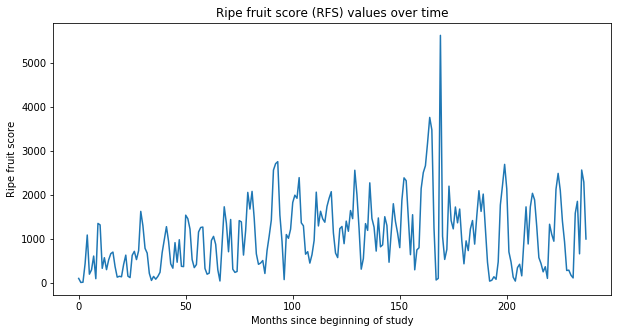

In [20]:
df = pd.read_csv('Ngogo ripe fruit phenology Nov 2018.csv')

plt.figure(figsize=(10,5))
plt.plot(df['RFS'])
plt.xlabel('Months since beginning of study')
plt.ylabel('Ripe fruit score')
plt.title('Ripe fruit score (RFS) values over time')
plt.show()

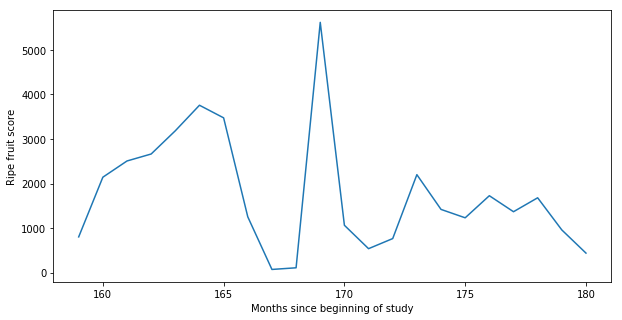

In [3]:
truncated_df = df.iloc[159:181,:]

plt.figure(figsize=(10,5))
plt.plot(truncated_df['RFS'])
plt.xlabel('Months since beginning of study')
plt.ylabel('Ripe fruit score')
plt.show()

From the graph above of RFS values between March 2011 and March 2013, it appears that the unusually large spike in fruit production was both preceded and proceeded by rather large drops in fruit production. This is likely a reflection of the fact that high reproductive activity among tropical forest trees must be followed by relative reproductive dormancy. It would be interesting to examine how these "boom-bust" periods affect foraging patterns in animals, such as chimpanzees, that rely on these food resources.

Below I look to see how RFS have varied among study years. The pattern here is similar to that from the monthly RFS investigation above - fruit production increases steadily until about 2011-2012. In this case, however, the "leveling off" appears slightly earlier in the study and is followed by a relatively large drop in average monthly RFS. This, combined with the relatively large error bars found in the later years of the study, suggests that fruit production has become more volatile since 2011-2012.

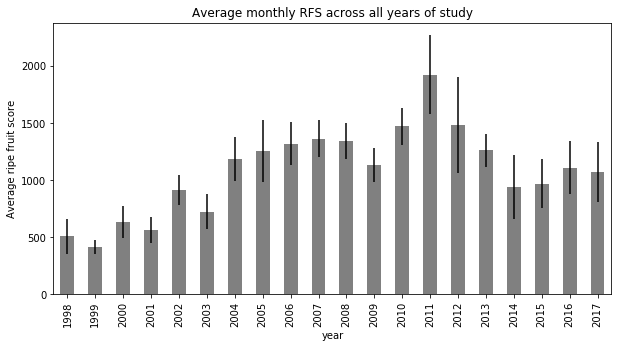

In [4]:
annual_RFS = df.groupby('year').aggregate(np.mean)
annual_se = df.groupby('year').sem()

plt.figure(figsize=(10,5))
annual_RFS['RFS'].plot(kind='bar', yerr=annual_se['RFS'], color='gray')
plt.ylabel('Average ripe fruit score')
plt.title('Average monthly RFS across all years of study')
plt.show()

In the next two cells I examine the extent of temporal autocorrelation among months in RFS values. It is well known to tropical ecologists that fruit produced by a tree in a given month often persists on the tree for several months, therefore fruiting "event" are rarely confined to a single month. A consequence of this is that the RFS in month x+1 (or x+2, x+3, etc.) may, to a certain extent, be dependent on the RFS in month x. The first cell below provides an array of monthly lag autocorrelation values (i.e., the correlation between the RFS value represented by a given array index and the value at array index 0), as well as an array of the corresponding confidence intervals. In the next cell, I have produced a figure depicting the values of this autocorrelation array. 

From these tests it is clear there is some autocorrelation among months, but it is not as substantial as I had anticipated. For the most part, it seems that there is first order autocorrelation (meaning there is correlation among two consecutive months), but beyond that the values are fairly small and confidence intervals are fairly wide, suggesing far less correlation. 

In [5]:
acf, confint = sm.tsa.stattools.acf(df['RFS'],nlags=12,alpha=.05)
print(acf)
print(confint)

[ 1.          0.53920856  0.24399448  0.09147601  0.05443086 -0.04397066
 -0.0901474  -0.04975789  0.04709334  0.19038337  0.26153497  0.3834432
  0.41831077]
[[ 1.          1.        ]
 [ 0.41216296  0.66625416]
 [ 0.08422527  0.40376368]
 [-0.07419838  0.25715041]
 [-0.11205676  0.22091848]
 [-0.21074526  0.12280394]
 [-0.25710901  0.07681422]
 [-0.21750327  0.1179875 ]
 [-0.12089011  0.21507679]
 [ 0.02218696  0.35857978]
 [ 0.08989556  0.43317439]
 [ 0.20548776  0.56139864]
 [ 0.22748521  0.60913634]]


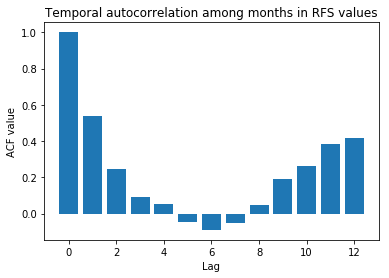

In [6]:
#Here I am checking the same thing as above, but with an ACF graph

plt.bar(
    x = list(range(0,13)), 
    height = acf
)
plt.xlabel('Lag')
plt.ylabel('ACF value')
plt.title('Temporal autocorrelation among months in RFS values')

plt.show()


Below are a few summary statistics describing RFS and the measured weather variables, as well as histograms depicting the variance and central tendency of the weather variables (I will examine the distribution of RFS more fully below). It is interesting to note here that both RFS and rainfall vary considerably over time, whereas temperature and, to a lesser extent irradiance, show very little variance. I will come back to this in one of my formal tests below. Also, temperature and irradiance more closely conform to a normal distribution, whereas rainfall shows far more right skew. 

In [7]:
df_short = pd.DataFrame()
df_short['RFS'] = df['RFS']
df_short['rainfall'] = df['rainfall']
df_short['avetemp'] = df['avetemp']
df_short['irradiance'] = df['irradiance']

df_short.describe()

,RFS,rainfall,avetemp,irradiance
count,238.000000,238.000000,238.000000,203.000000
mean,1080.599282,118.240336,20.641927,225.807882
std,797.393473,70.494780,0.842772,19.148392
min,15.274089,3.700000,19.000000,184.000000
25%,443.370416,59.400000,20.016667,211.500000
50%,962.876784,107.550000,20.564516,225.000000
75%,1476.755551,167.550000,21.000000,236.000000
max,5619.569821,340.000000,23.500000,282.000000


c:\users\kevin\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\kevin\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


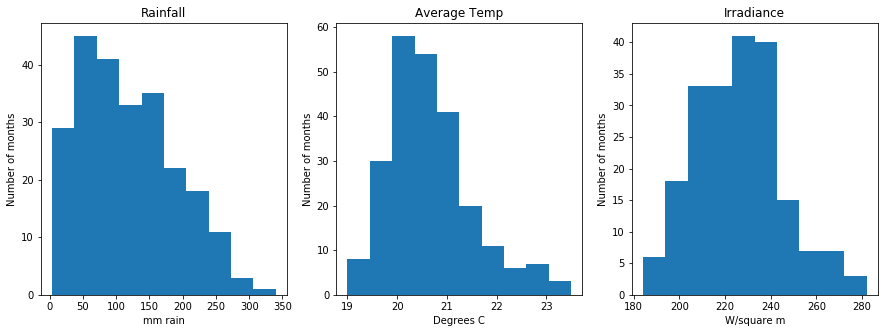

In [8]:
plt.figure(figsize=(15,5));

plt.subplot(1,3,1);
plt.hist(df_short['rainfall']);
plt.title('Rainfall');
plt.xlabel('mm rain');
plt.ylabel('Number of months');

plt.subplot(1,3,2)
plt.hist(df_short['avetemp'])
plt.title('Average Temp')
plt.xlabel('Degrees C')
plt.ylabel('Number of months');

plt.subplot(1,3,3)
plt.hist(df_short['irradiance'])
plt.title('Irradiance')
plt.xlabel('W/square m')
plt.ylabel('Number of months');

plt.show();

In the figure below I wanted to get a general sense of how RFS and the three weather variables change, on average, across months. Rainfall appears to have a bimodal distribution, with the highest totals falling in April and October, whereas temperature and irradiance tend to follow a pattern in which values reach a minimum around August, steadily rise until February, then begin to decline. It is interesting to note that RFS reaches something of a peak in October-November, which represents a time of generally low temperatures, low solar radiation, and high rainfall. 

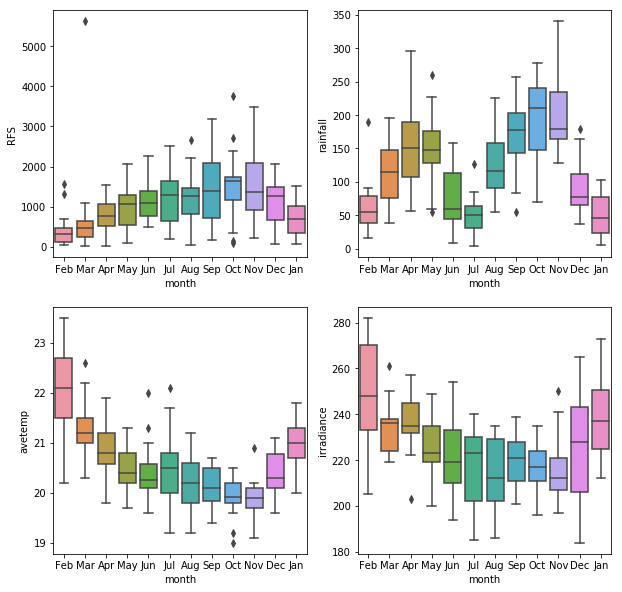

In [9]:
df_short['month'] = df['month']

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
sn.boxplot(x=df_short['month'], y=df_short['RFS'])

plt.subplot(2,2,2)
sn.boxplot(x=df_short['month'], y=df_short['rainfall'])

plt.subplot(2,2,3)
sn.boxplot(x=df_short['month'], y=df_short['avetemp'])

plt.subplot(2,2,4)
sn.boxplot(x=df_short['month'], y=df_short['irradiance'])


plt.show()

In the cell below I have created a dictionary that includes dates as keys and ripe fruit scores corresponding to those dates as values. I can use this dictionary as a sort of querying tool to, for example, determine in which month the RFS was maximized and minimized. The dictionary could be easily modified to provide easy access to dates linked to other events of interest (e.g., dates of longest consecutive period of low fruit availability)

In [10]:
RFS_dict = {}
values = []
keys = []
for score in df['RFS']:
    values.append(score)
for i in df['date']:
    keys.append(i)
for i in range(len(values)): 
    RFS_dict[keys[i]] = values[i]

#Determine the dates corresponding to lowest and highest RFS:

for date,score in RFS_dict.items():
    if score == max(RFS_dict.values()):
        print ("The highest ripe fruit score was {}, which occurred in {}".format(score, date))
    if score == min(RFS_dict.values()):
        print("The lowest ripe fruit score was {}, which occurred in {}".format(score, date))

The lowest ripe fruit score was 15.27408857, which occurred in Mar-98
The highest ripe fruit score was 5619.569821, which occurred in 12-Mar


###### Question #1: What is the relationship among the measured weather variables?

In this question, I am interested in looking at the interrelationships among temperature, rainfall, and irradiance. Going on a priori understanding of tropical weather patterns, I am hypothesizing that 1) as rainfall increases, temperatures and irradiance values should decrease, and 2) as irradiance increases, temperature should increase. These hypothesized relationships have to do with cloud cover - as cloud cover increases (with increased rainfall), this limits the amount of solar radiation hitting the weather station in the research camp and, therefore, reduces temperature. Similarly, as clouds recede and irradiance increases, this should increase temperatures. Discerning these relationships are important for understanding how weather patterns might influence fruit production, and for predicting how future climatic changes might impact fruit production.

Below I assess these three relationships visually using scatterplots, and statistically using the lingress function in scipy program.

Overall, it seems that only the relationship between irradiance and temperature is particularly strong. Though the linear regression models explaining these three relationships (shown in the graphs below) are all statistically significant, the fairly low R-squared values of the first two relationships, in particular, suggest that rainfall explains relatively little of the variance in either temperatures or irradiance. 

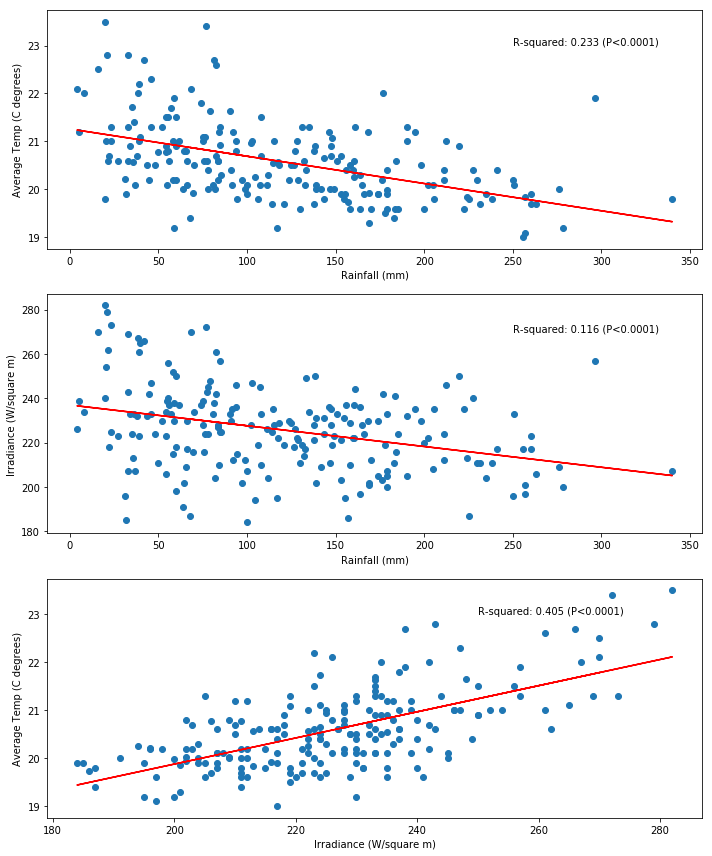

In [11]:
df2 = df_short.dropna()

x1=df2['rainfall']
y1=df2['avetemp']
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1,y1)

x2=df2['rainfall']
y2=df2['irradiance']
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2,y2)

x3=df2['irradiance']
y3=df2['avetemp']
slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(x3,y3)

plt.figure(figsize=(10,12))

plt.subplot(3,1,1)
plt.scatter(x1,y1)
plt.plot(x1,intercept1+slope1*x1, 'r')
plt.annotate('R-squared: {} (P<0.0001)'.format(str((r_value1**2))[0:5]), (250,23))
plt.xlabel('Rainfall (mm)')
plt.ylabel('Average Temp (C degrees)')

plt.subplot(3,1,2)
plt.scatter(x2,y2)
plt.plot(x2,intercept2+slope2*x2, 'r')
plt.annotate('R-squared: {} (P<0.0001)'.format(str((r_value2**2))[0:5]), (250,270))
plt.xlabel('Rainfall (mm)')
plt.ylabel('Irradiance (W/square m)')

plt.subplot(3,1,3)
plt.scatter(x3,y3)
plt.plot(x3,intercept3+slope3*x3, 'r')
plt.annotate('R-squared: {} (P<0.0001)'.format(str((r_value3**2))[0:5]), (250,23))
plt.xlabel('Irradiance (W/square m)')
plt.ylabel('Average Temp (C degrees)')

plt.tight_layout()

plt.show()

###### Question #2: What factors influence monthly fruit production?

My second main question concerns which variables most closely influence the month-to-month fluctuation in fruit availability in this forest. This question has clear relevance for predicting how future climate change might influence the productivity patterns of the forest and, by extension, the foraging and population dynamics of animals, such as chimpanzees, that rely on fruit resources.

I begin in a somewhat general way in the first cell below by examining univariate relationships between RFS and the three weather variables to get a sense of how these predictor variables (rainfall, irradiance, temperature) might impact RFS when put into a more formal and rigorous multivariate analysis. In these graphs, the blue line is an ordinary least squares regression line, and the shaded bands surround the line are 95% confidence bands. 

One thing to note from the graphs in the cell below is that there is an apparent outlier in the RFS variable (a score of over 5000, where the next lowest score is around 3500). I did not show it here, but I re-ran these plots with that point removed, and it did not substantially change the relationships.

c:\users\kevin\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


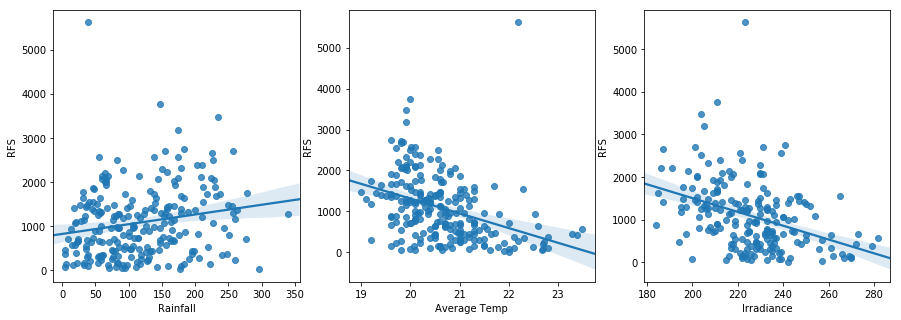

In [12]:
plt.figure(figsize=(15,5));

plt.subplot(1,3,1);
sn.regplot(x=df_short['rainfall'], y=df_short['RFS']);
plt.xlabel('Rainfall');
plt.ylabel('RFS');


plt.subplot(1,3,2);
sn.regplot(x=df_short['avetemp'], y=df_short['RFS']);
plt.xlabel('Average Temp');


plt.subplot(1,3,3);
sn.regplot(x=df_short['irradiance'], y=df_short['RFS']);
plt.xlabel('Irradiance');                     

plt.show();

Before constructing a multivariate regression model to explore the influence of our various predictor variables on RFS, an important first step is to determine the distribution of the data in the RFS variable. This will help to inform what type of test can be performed on the data.

From the first histogram below, depicting frequencies of RFS values, it generally looks like the data may follow a gamma distribution. It is certainly not normally distributed, and the strong right skew, plus the fact that the data are bounded by zero and are continuous (as opposed to integer scale), suggest a gamma distribution. However, to more formally test this I fit a gamma distribution against the RFS histogram in the second figure below.

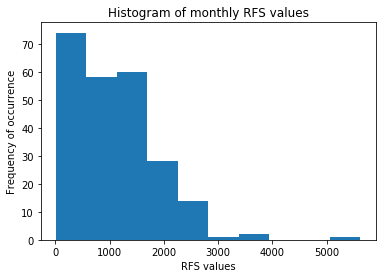

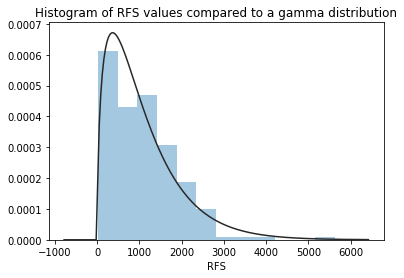

In [13]:
histplot = plt.hist(df['RFS'])
plt.xlabel('RFS values')
plt.ylabel('Frequency of occurrence')
plt.title('Histogram of monthly RFS values')
plt.show()

#It looks like the data may follow a gamma distribution. We can check this by fitting a gamma distribution against our data to
#see how closely they correspond
sn.distplot(df['RFS'], bins=12, fit=stats.gamma, hist=True, kde=False)
plt.title('Histogram of RFS values compared to a gamma distribution')
plt.show()





I feel pretty confident that a gamma distribution is appropriate for this response variable, so I will specify this in the multivariate model below. In this model, I use the pyGAM program to fit a generalized additive model to the relationship between RFS (the response variable) and rainfall, temperature, irradiance, date, and month (the predictor variables). Generalized additive models are similar to standard generalized linear models, except that they allow for the inclusion of clearly non-linear "smooth" functions (the "smoothing" being created by applying a certain penalty to the various splines making up the hypothesized non-linear variable). In this case, because "month" should have a more or less cyclical relationship with RFS, and RFS increases exponentially with "date" until about 3/4 of the way through the study, at which point the relationship becomes flat. These are non-linear relationships that can be modeled using the smooth functions of generalized additive models.

The model described in the cell input and output directly below uses a gamma distribution and log link function (there are other possible link functions to use with a gamma distribution, but other options did not substantially change the outcome). There is a lot of information contained in the model summary box, and as the warnings imply this is a fairly new program that still has some bugs to be worked out, so not all the results can be fully trusted. However, it seems that both the smooth functions, month and date, strongly predict RFS values from month to month, whereas relatively few of the weather variables do (with the exception of temperature (l(3)) which, the caveat about the p-values being likely much smaller than they should be not withstanding, may predict RFS to a lesser extent).

In the second cell below I present graphs depicting the smooth and linear functions determined for each predictor variable. Solid gray lines are the fitted functions and dotted lines are 95% confidence bands. Note the relatively modest values of the linear functions compared to the smooth functions, suggesting both short term (month to month) variability and a long-term increasing trend characterize the RFS, and that the weather variables we have measured do not adequately explain those trends.

We can conclude that it is likely that large-scale climatic forces, those producing seasonal changes and those producing the long-term increasing trend in forest productivity being seen across much of the tropics over the last several decades, best predict fruit productivity in the Kibale Forest, and that more localized weather patterns have seemingly less of an effect. This is considerably useful information if we are attempting to understand the future of this forest and its inhabitants - large-scale climatic changes, which have been well documented worldwide, are likely to have a fairly direct influence on the future productivity of the trees in this forest.

In [14]:
from pygam import GAM, s, l 

df1 = pd.DataFrame.dropna(df, axis = 0)

x = df1[['NumericDate','NumericMonth','rainfall','avetemp','irradiance']]
y = df1['RFS']

GAMmodel1 = GAM(
    s(0) + s(1) + l(2) + l(3) + l(4), 
    distribution = 'gamma',
    link = 'log',
    ).fit(x,y)

GAMmodel1.summary()





GAM                                                                                                       
=============================================== ==========================================================
Distribution:                         GammaDist Effective DoF:                                     23.3685
Link Function:                          LogLink Log Likelihood:                                 -1363.2706
Number of Samples:                          179 AIC:                                             2775.2783
                                                AICc:                                             2783.326
                                                GCV:                                                0.5797
                                                Scale:                                              0.3821
                                                Pseudo R-Squared:                                   0.4449
Feature Function                  Lam

c:\users\kevin\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  


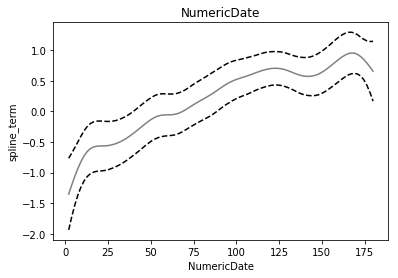

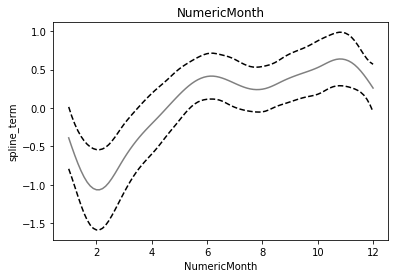

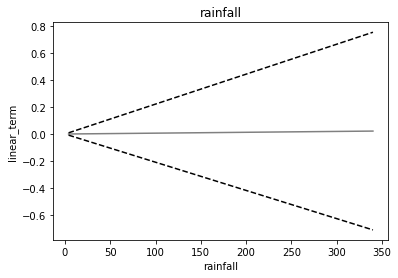

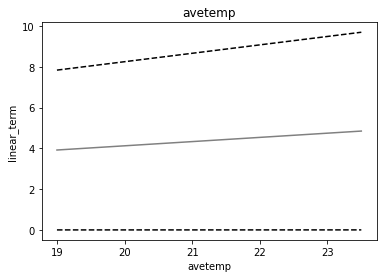

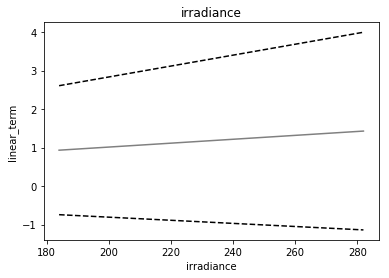

In [15]:
for i, term in enumerate(GAMmodel1.terms):
    if term.isintercept:
        continue

    grid = GAMmodel1.generate_X_grid(term=i)
    funct, ci = GAMmodel1.partial_dependence(term=i, X=grid, width=0.95)

    plt.figure()
    plt.plot(grid[:, term.feature], funct, c='grey')
    plt.plot(grid[:, term.feature], ci, c='black', ls='--')
    plt.title(list(x)[i])
    plt.xlabel(list(x)[i])
    plt.ylabel(list(GAMmodel1.terms)[i])
    plt.show()

###### Question #3: What is the frequency and distribution of prolonged periods of particularly low or high fruit abundance? 

Because chimpanzees and other fruit-eating mammals and birds in the Kibale Forest rely on a steady, relatively invariant resource base, prolonged periods of low fruit availability can have profound impacts on their ability to find adequate calories and nutrients. Conversely, prolonged periods of unusally high abundance can provide fruit-eating animals with an excess of calories that they can then use for reproduction and other metabolically expensive activities. In this question, I would like to see how these "shortfall" and "bonanza" periods are distributed across years of this study, and to see whether either type is becoming more or less common. 

One issue with this question is that, as we will see below, the sample size here will be rather small (it is rare to find a prolonged period of either shortfall or bonanza). The other issue, of course, is how do we define "prolonged" and how do we define "unusually low or unusually high"? 

I will define a "prolonged period of unusually low fruit availability (i.e., a "shortfall") as two or more consecutive months in which the RFS is less than one standard deviation below the long-term mean RFS. Similarly, a prolonged period of unusually high fruit availability (i.e., a "bonanza") is two or more consecutive months in which the RFS is greater than one standard deviation above the long-term mean. 

In the first cell below, I have created a list indices corresponding to the year in which a shortfall begins, and a separate list of those in which a bonanza begins.

In [16]:

low_cutoff = df['RFS'].mean() - df['RFS'].std()
high_cutoff = df['RFS'].mean() + df['RFS'].std()

RFS = df['RFS']

shortfalls = []
for index,score in enumerate(RFS):
    if index < 237:
        x = RFS[index]
        y = RFS[index + 1]
        if x<low_cutoff and y<low_cutoff:
            shortfalls.append(index)

bonanzas = []
for index,score in enumerate(RFS):
    if index < 237:
        x = RFS[index]
        y = RFS[index + 1]
        if x>high_cutoff and y>high_cutoff:
            bonanzas.append(index)     
    
print(shortfalls)
print(bonanzas)


[0, 1, 18, 19, 23, 33, 34, 35, 36, 37, 60, 73, 167, 192, 193, 194, 203, 230]
[91, 92, 101, 102, 117, 129, 151, 152, 160, 161, 162, 163, 164, 198, 199, 212, 223, 224, 235]


These lists give us some raw data on how many shortfalls and bonanzas there have been, but there is no temporal signature at this point. Below I input some additional code to provide a means of assessing when particular shortfalls and bonanzas occurred. 

In [17]:
years_w_shortfalls = df.loc[shortfalls].groupby('year').count()
years_w_bonanzas = df.loc[bonanzas].groupby('year').count()

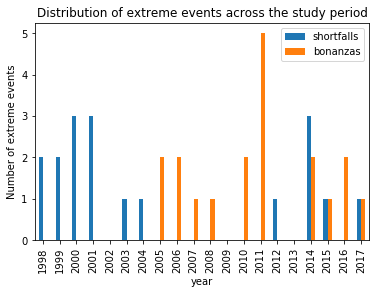

In [18]:
all_years = list(range(1998,2018))
all_years_shortfalls = []
all_years_bonanzas = []

for year in all_years:
    if year in list(years_w_shortfalls.index):
        all_years_shortfalls.append(years_w_shortfalls['RFS'][year])
    else:
        all_years_shortfalls.append(0)

for year in all_years:
    if year in list(years_w_bonanzas.index):
        all_years_bonanzas.append(years_w_bonanzas['RFS'][year])
    else:
        all_years_bonanzas.append(0)
        
all_extremes_df = pd.DataFrame()
all_extremes_df['year'] = all_years
all_extremes_df['shortfalls'] = all_years_shortfalls
all_extremes_df['bonanzas'] = all_years_bonanzas

all_extremes_df.plot.bar(x='year')
plt.ylabel('Number of extreme events')
plt.title('Distribution of extreme events across the study period')
plt.show()

Though the sample size is small, it generally appears that shortfalls occurred more regularly early on in the study period and have become less common across years in the later stages of the study (though it is interesting to note that, in 2014, there were three such events, meaning that half of the year was spent in shortfall, while another 1/6 of the year was spent in bonanza). Bonanzas were relatively rare in the early years of the study but have generally become more common since 2005, hitting their peak in 2011 (with five bonanza periods, meaning that all but two of the months that year qualified as unusually high abundance months). One very intriguing anecdote related to this pattern is that the chimpanzee population size at this site in Kibale increased dramatically after 2011, due to a period of unusually high birth rates and infant survival. It is likely that the high food supply during this period helped to support this population growth.

It is also noteworthy that the last few years have, in many cases, experienced both shortfalls and bonanzas in the same year. This is apparently unusual. In fact, in no year prior to 2014 did a single given year experience both a shortfall and a bonanza, but since 2014 all but one year has experienced both. This is likely a reflection of the increased volatility in fruit production patterns, which I noted above.

###### Further Research:

This preliminary project really just scrapes the surface of what can be done using a data science toolkit to address questions related to fruit productivity patterns in the Kibale National Park. One question I would like to delve into is: how have fruiting patterns at the species level influenced the overall pattern in RFS variability over time? For example, what species are producing fruit during bonanzas? During shortfalls? This is critically important for understanding how future changes to the forest might impact animal populations that depend on these tree species as food resources. I would begin to address this by merging relevant fields from the ripe fruit phenology file I used here with an additional file that includes species-level fruiting data (perhaps using something like "date" as the unique identifier common to both files). I could then use an SQL editor, such as postgreSQL, to set up queries to find, for example, what were the top 3 fruit-producing species during each bonanza period? Or, during shortfalls, what are the species most likely to be producing fruit? There are an endless number of similar questions that could be addressed through this fairly simple SQL querying procedure.  